![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [75]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

# for lasso
from sklearn.linear_model import Lasso
# for Linear Regression
from sklearn.linear_model import LinearRegression
# for Random Forest
from sklearn.ensemble import RandomForestRegressor

In [76]:
# Read the data

rental_info = pd.read_csv("rental_info.csv")
rental_info.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [77]:
# Check for missing values

rental_info.isna().sum()

rental_date         0
return_date         0
amount              0
release_year        0
rental_rate         0
length              0
replacement_cost    0
special_features    0
NC-17               0
PG                  0
PG-13               0
R                   0
amount_2            0
length_2            0
rental_rate_2       0
dtype: int64

In [78]:
rental_info.describe().T

,count,mean,std,min,25%,50%,75%,max
amount,15861.0,4.217161,2.360383,0.9900,2.9900,3.9900,4.9900,11.9900
release_year,15861.0,2006.885379,2.025027,2004.0000,2005.0000,2007.0000,2009.0000,2010.0000
rental_rate,15861.0,2.944101,1.649766,0.9900,0.9900,2.9900,4.9900,4.9900
length,15861.0,114.994578,40.114715,46.0000,81.0000,114.0000,148.0000,185.0000
replacement_cost,15861.0,20.224727,6.083784,9.9900,14.9900,20.9900,25.9900,29.9900
NC-17,15861.0,0.204842,0.403599,0.0000,0.0000,0.0000,0.0000,1.0000
PG,15861.0,0.200303,0.400239,0.0000,0.0000,0.0000,0.0000,1.0000
PG-13,15861.0,0.223378,0.416523,0.0000,0.0000,0.0000,0.0000,1.0000
R,15861.0,0.198726,0.399054,0.0000,0.0000,0.0000,0.0000,1.0000
amount_2,15861.0,23.355504,23.503164,0.9801,8.9401,15.9201,24.9001,143.7601


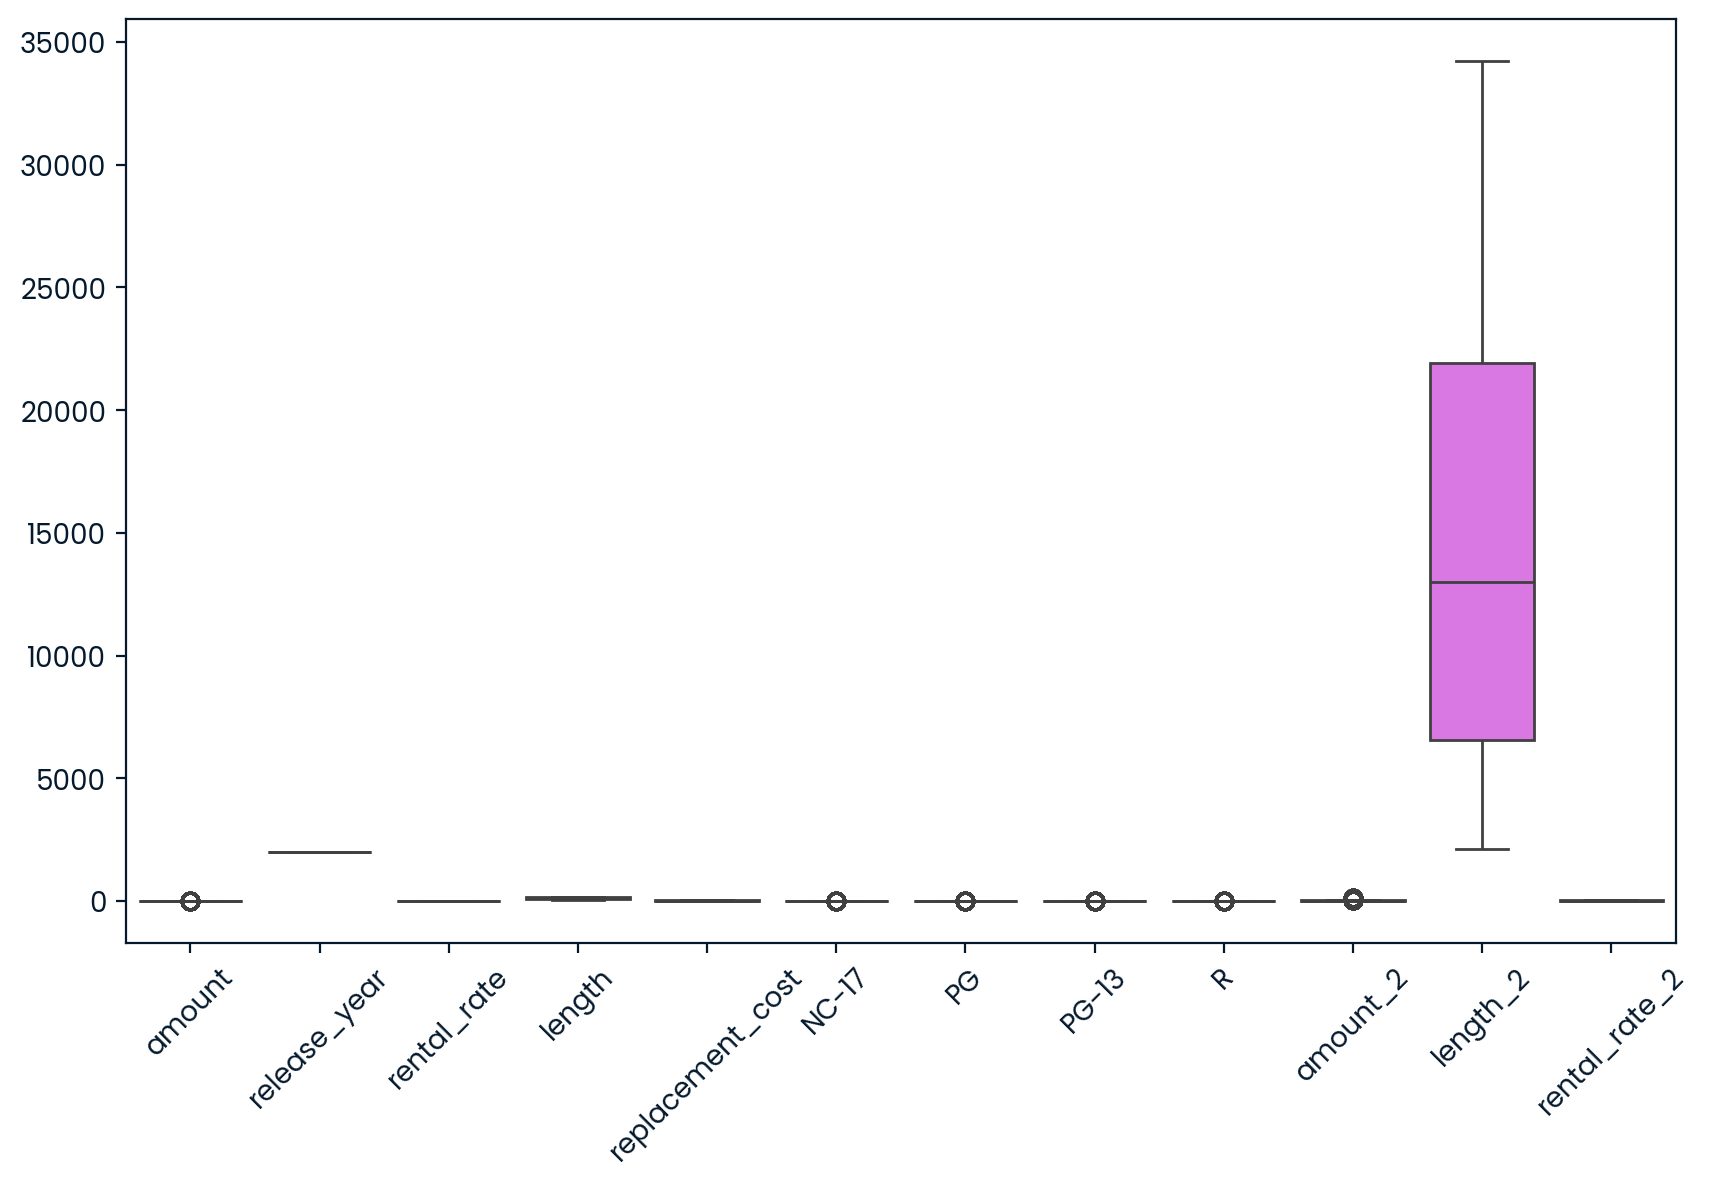

In [79]:
# Quick check to see any potential outlier

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.boxplot(data=rental_info)
plt.xticks(rotation=45)
plt.show()

In [80]:
# Creating column for rental lenght days

rental_info['rental_length'] = pd.to_datetime(rental_info["return_date"]) - pd.to_datetime(rental_info["rental_date"])
rental_info['rental_length_days'] = rental_info['rental_length'].dt.days

In [81]:
# Create dummy variables

rental_info["deleted_scenes"] = np.where(rental_info["special_features"].str.contains("Deleted Scenes"), 1, 0)
rental_info["behind_the_scenes"] = np.where(rental_info["special_features"].str.contains("Behind the Scenes"), 1, 0)

In [82]:
# Set the X and y features

col_to_drop = ["special_features", "rental_length", "return_date", "rental_date", "rental_length_days"]
X = rental_info.drop(col_to_drop, axis=1)
y = rental_info["rental_length_days"]

In [83]:
# Split the data into X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 9)

In [84]:
# Laso Regresion for feature importance

lasso = Lasso(alpha = 0.3)
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_

In [85]:
# Split to choose features with best lasso coef (Feature Selection)

X_lasso_train, X_lasso_test = X_train.iloc[:, lasso_coef>0], X_test.iloc[:, lasso_coef>0]

# Use the lasso X_train and X_test for the Linear Regression Model
# Create Linear Regression
lrg = LinearRegression()
lrg.fit(X_lasso_train, y_train)
lrg_pred = lrg.predict(X_lasso_test)

In [86]:
# MSE for Linear Regression

mse_lrg = mean_squared_error(y_test, lrg_pred)
mse_lrg

4.812297241276244

In [87]:
# Random Forest hyperparameter
parameters = {"n_estimators": np.arange(1,101,1),
             "max_depth": np.arange(1,11,1)}
# create random forest model
rf = RandomForestRegressor()
# Cross validation tuning
random_search = RandomizedSearchCV(rf, param_distributions = parameters, cv=5, random_state=9)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])},
                   random_state=9)

In [88]:
best_params_rf = random_search.best_params_
best_params_rf

{'n_estimators': 51, 'max_depth': 10}

In [89]:
# Now, use the best parameters for random forest regression

rf = RandomForestRegressor(n_estimators = best_params_rf['n_estimators'],
                          max_depth = best_params_rf['max_depth'])
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [90]:
# MSE for Random Forest Regression

mse_rf = mean_squared_error(y_test, rf_pred)
mse_rf

2.2190630116795464

In [91]:
best_model = rf
best_mse = mse_rf